In [8]:
import pymongo as pm #import MongoClient only
from pymongo import MongoClient
import pprint # prettyprinting for json objects
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#Database connexion
client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use


# Step 2 -  Car sharing usage 

## Question 1

In [9]:
#Some practical implementations

# Collections
bookings_collection = db['PermanentBookings']
parkings_collection = db['PermanentParkings']

# Define date range for querying
start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31, 23, 59, 59)

# Define the cities to analyze
cities = ["Madrid", "Denver", "Austin"]



### Code

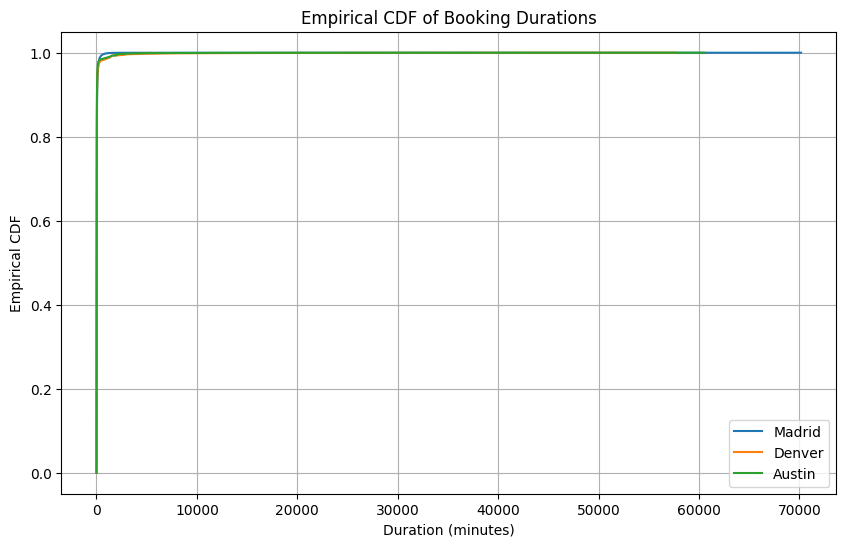

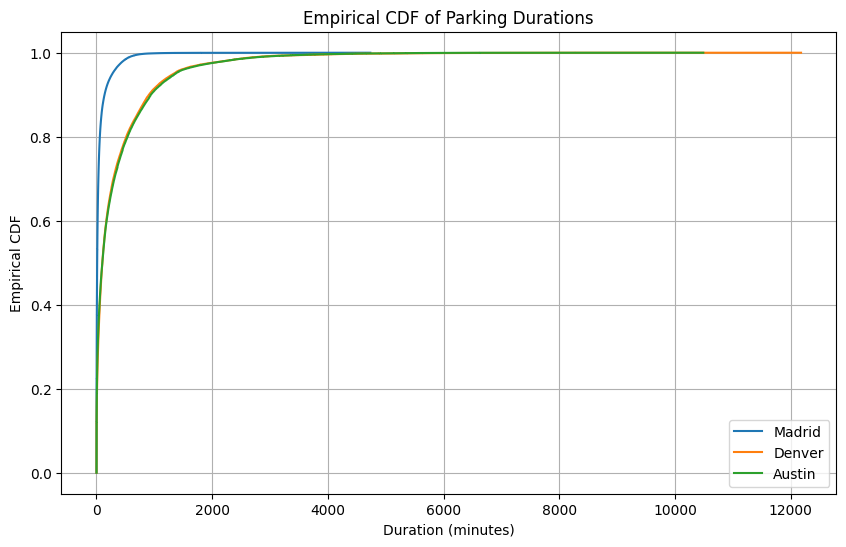

In [12]:
# Function to retrieve and process data for bookings or parkings
def get_durations(collection, city):
    # Query to filter by city and date range
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lte': end_date},
        'final_date': {'$exists': True}  # Ensure final_date exists
    }
    # Fields to retrieve
    projection = {
        '_id': 0,
        'init_date': 1,
        'final_date': 1
    }
    # Retrieve data
    data = list(collection.find(query, projection))
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Ensure dates are datetime objects
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])
    # Compute duration in minutes
    df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
    # Filter out any negative or zero durations (if any)
    df = df[df['duration'] > 0]
    return df['duration']

# Initialize dictionaries to hold durations
booking_durations = {}
parking_durations = {}

# Retrieve durations for each city
for city in cities:
    booking_durations[city] = get_durations(bookings_collection, city)
    parking_durations[city] = get_durations(parkings_collection, city)


def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=city)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot CDFs for bookings
plot_cdf(booking_durations, 'Empirical CDF of Booking Durations')

# Plot CDFs for parkings
plot_cdf(parking_durations, 'Empirical CDF of Parking Durations')


### Interpretation

a. Density for Larger Values of Duration

Madrid’s CDF curve rises the quickest and reaches near 1.0 earlier than Denver and Austin, indicating that Madrid has a higher density of shorter parking durations.
Denver and Austin have slower-rising CDFs, which means they tend to have a greater density of larger parking durations compared to Madrid.
Of the three, Austin appears to have the slowest rise in the CDF in the mid-range (around 1000-5000 minutes), suggesting that it has a larger proportion of long-duration parkings.
Is This Expected?

This might be expected if there are city-specific factors influencing parking behavior. For instance, Madrid might have stricter rules or higher turnover in parking spots, encouraging shorter parking times.
Austin's slower rise in the CDF could indicate that users park for longer durations, which could be due to larger or more readily available parking spaces, or user patterns unique to that city.
Outliers:The tail extending to very high values of parking duration (above 8000 minutes) suggests the presence of outliers in the data.
These could represent vehicles left parked for abnormally long periods, possibly due to inactivity or service issues.
The CDFs reaching 1.0 with these extreme durations suggest that these values are rare, but they are still influencing the overall distribution.

b. Differences in the CDFs
Madrid’s Sharp Rise: Madrid’s CDF rises sharply at lower durations, indicating that most parkings are relatively short. This could reflect a high turnover rate, possibly driven by high demand or short-distance usage patterns.
Denver and Austin’s Gradual Increase:
Both Denver and Austin show slower increases in the CDF, particularly Austin. This suggests that a significant portion of parkings in these cities have longer durations.
These differences might be attributed to factors like urban layout, parking policies, and usage habits specific to each city.
Summary Interpretation
Madrid has shorter parking durations, likely due to higher turnover or restrictions.
Austin has the longest parking durations among the three, suggesting either more relaxed parking or different usage patterns.
Outliers in the form of extremely long parking durations exist in all cities and may require further investigation to understand if they represent actual usage or anomalies in the data.

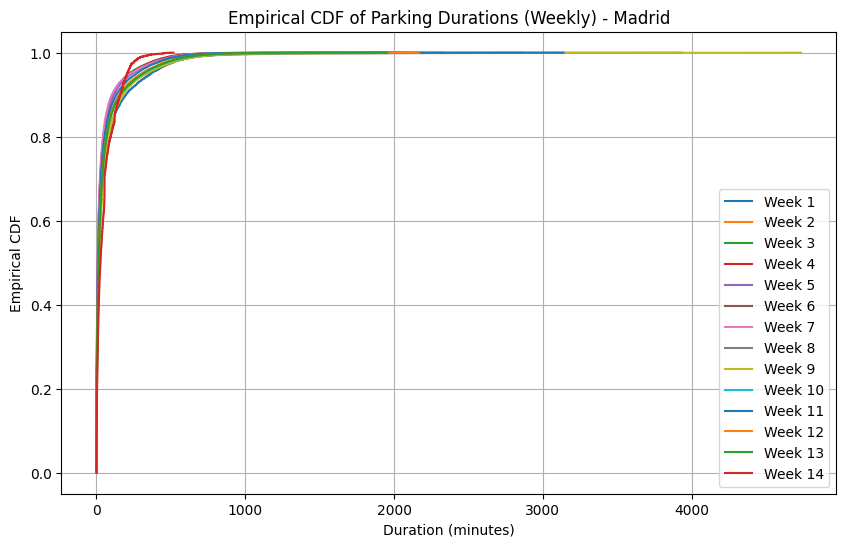

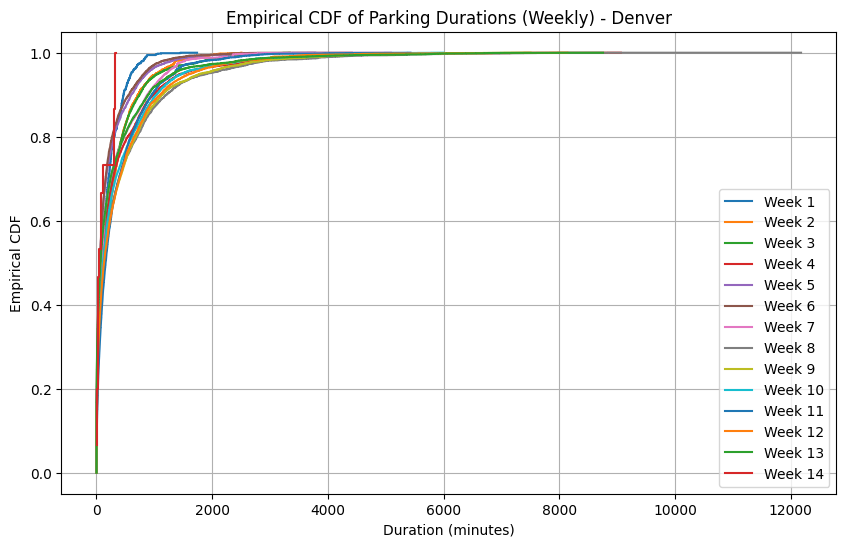

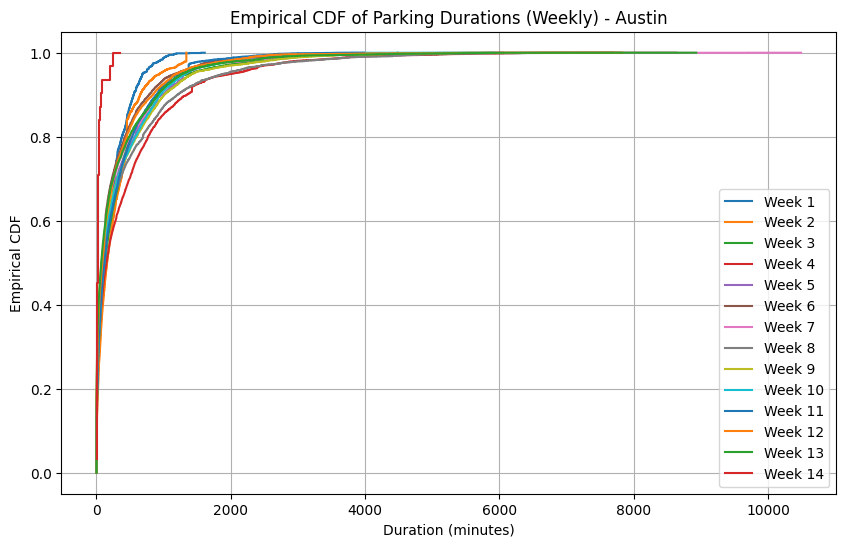

In [13]:
from datetime import timedelta

def get_weekly_durations(collection, city):
    """Retrieve durations by weekly periods for a specific city."""
    weekly_durations = {}
    start_date = datetime(2017, 11, 1)
    end_date = datetime(2018, 1, 31, 23, 59, 59)
    week = 0

    while start_date < end_date:
        week_end = start_date + timedelta(days=7)
        # Query to filter by city and weekly date range
        query = {
            'city': city,
            'init_date': {'$gte': start_date, '$lt': week_end},
            'final_date': {'$exists': True}
        }
        # Retrieve data and compute duration as before
        data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
        df = pd.DataFrame(data)
        if not df.empty:
            df['init_date'] = pd.to_datetime(df['init_date'])
            df['final_date'] = pd.to_datetime(df['final_date'])
            df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
            df = df[df['duration'] > 0]
            weekly_durations[f"Week {week + 1}"] = df['duration']
        start_date = week_end
        week += 1

    return weekly_durations

# Plot weekly CDFs for each city
for city in cities:
    weekly_durations = get_weekly_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for week, durations in weekly_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=week)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(f'Empirical CDF of Parking Durations (Weekly) - {city}')
    plt.legend()
    plt.grid(True)
    plt.show()


Madrid:

The weekly CDFs for Madrid are relatively consistent, with most weeks following a similar distribution for parking durations.
There is a slight variation between some weeks, particularly in the initial rise of the CDF, indicating some fluctuation in short-duration parking usage.
Overall, most weeks in Madrid show a rapid rise in the CDF, suggesting that a high proportion of parking events are of shorter durations. This consistency might imply stable user behavior across weeks.
Denver:

In Denver, there is slightly more variation between weeks than in Madrid, especially for short parking durations (0–1000 minutes).
Some weeks show a slower rise in the CDF, suggesting more parking events of longer durations during those weeks.
This variability could indicate weekly changes in user behavior or external factors affecting parking times, such as local events, weather conditions, or demand fluctuations.
Austin:

The weekly CDFs in Austin show similar characteristics to those in Denver, with some noticeable variability between weeks.
A few weeks (e.g., Week 1 and Week 4) display a sharper initial rise, indicating shorter average parking durations, while other weeks show a slower rise, suggesting more longer-duration parking events.
This variability could be due to similar factors as in Denver, such as weekly events, changes in demand, or varying user patterns.
General Observations Across Cities
Variation in Short-Duration Parkings:

Across all cities, we observe slight weekly differences in the CDF curves, particularly in the initial rise. This suggests that the proportion of short-duration parking events fluctuates from week to week, likely due to changes in demand or usage patterns.
Longer-Duration Parkings:

For all three cities, the CDFs level off near 1.0 at around 3000-4000 minutes, indicating that very long-duration parking events are relatively rare but still present in some weeks.
These longer parkings might represent outliers or special circumstances, such as extended parking during weekends or holidays.
Summary of Findings
CDF Stability: While there is some variation between weeks, especially for short-duration parking, the overall weekly patterns are relatively stable, with all cities showing a high concentration of shorter parking durations.
City-Specific Patterns: Madrid shows the least weekly variability, while Denver and Austin display more noticeable fluctuations. This could indicate that Madrid's car-sharing usage is more consistent, whereas Denver and Austin have more dynamic or event-driven parking patterns.
Potential Influencing Factors: The weekly variations in Denver and Austin might be driven by local events, weather changes, or specific user behaviors that fluctuate week by week.

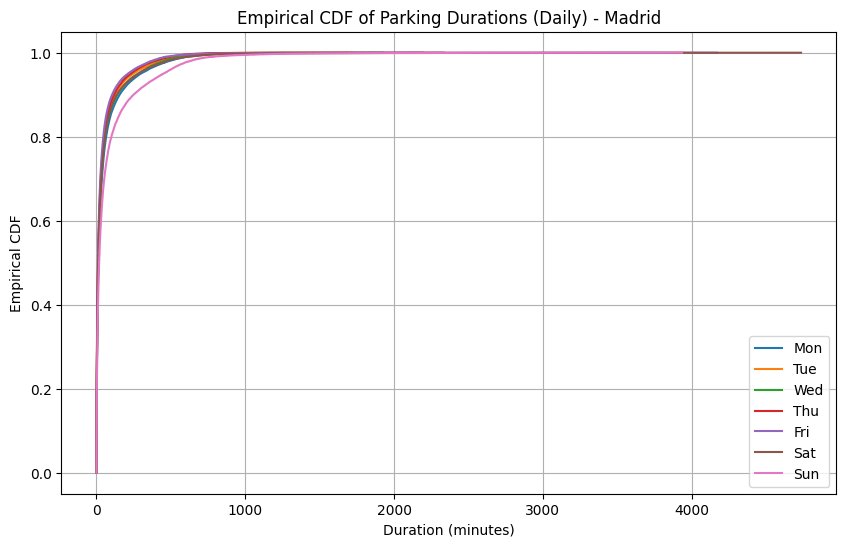

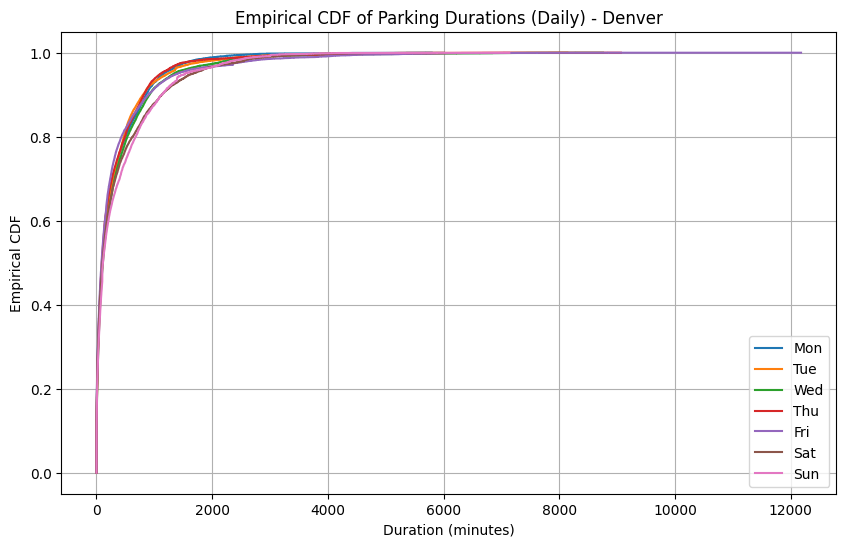

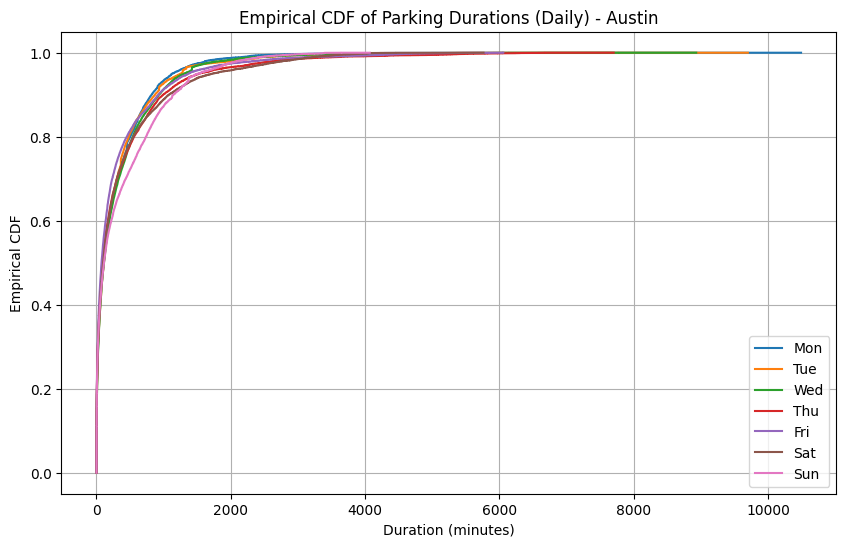

In [14]:
def get_daily_durations(collection, city):
    """Retrieve durations by day of the week for a specific city."""
    daily_durations = {day: [] for day in range(7)}  # 0=Monday, ..., 6=Sunday
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lt': end_date},
        'final_date': {'$exists': True}
    }
    # Retrieve data and calculate durations
    data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
    df = pd.DataFrame(data)
    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['final_date'] = pd.to_datetime(df['final_date'])
        df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
        df = df[df['duration'] > 0]
        df['day_of_week'] = df['init_date'].dt.dayofweek  # 0=Monday, ..., 6=Sunday
        for day in range(7):
            daily_durations[day] = df[df['day_of_week'] == day]['duration']
    return daily_durations

# Plot daily CDFs for each city
for city in cities:
    daily_durations = get_daily_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for day, durations in daily_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day])
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(f'Empirical CDF of Parking Durations (Daily) - {city}')
    plt.legend()
    plt.grid(True)
    plt.show()


Madrid: The daily CDFs for Madrid are very similar, with only minor differences across the days. This suggests that parking duration patterns are relatively consistent throughout the week.
Slight Variation on Sundays: Sundays show a slightly slower rise in the CDF, indicating that parking durations might be marginally longer on this day. This could be due to less frequent car usage or extended parking durations for weekend activities.
Overall, the CDFs suggest stable parking behavior in Madrid, with only minor variations between weekdays and weekends.
Denver:

Denver's daily CDFs show a bit more variation than Madrid’s, especially on the weekends (Saturday and Sunday).
Longer Parking Durations on Weekends: The slower rise in the CDF on weekends (especially Sunday) suggests that cars are left parked for longer durations compared to weekdays. This pattern may reflect reduced weekday commuting and an increase in longer leisure-related parking.
The weekday CDFs are relatively consistent, indicating that weekday parking patterns in Denver are stable and likely driven by regular commuting behavior.
Austin:

Austin displays a pattern similar to Denver, where the weekend (especially Sunday) shows a slower rise in the CDF, suggesting longer parking durations.
Weekday vs. Weekend Differences: Like Denver, Austin shows a consistent pattern on weekdays, with shorter parking durations. Weekend usage seems to involve longer parkings, which might reflect lower turnover or less frequent use.
The weekday CDFs in Austin are almost identical, implying that users have consistent parking durations on these days.
General Observations Across Cities
Consistent Weekday Patterns: For all three cities, weekday CDFs are fairly consistent, indicating that parking behavior on weekdays is likely driven by predictable commuting patterns.
Longer Parking Durations on Weekends: In both Denver and Austin, and to a lesser extent in Madrid, weekends show longer parking durations. This may reflect a shift toward leisure activities, where cars are left parked for extended periods, possibly overnight or for full-day events.
Summary of Findings
Stable Weekday Parking: Weekday parking patterns are consistent across all cities, suggesting they are influenced by regular work or commuting schedules.
Weekend Differences: Weekends, especially Sundays, show longer parking durations, particularly in Denver and Austin. This is likely due to leisure activities and reduced vehicle turnover.
City-Specific Behavior: Madrid shows minimal day-to-day variation, indicating a relatively stable usage pattern throughout the week, while Denver and Austin display more distinct weekend behavior.

## Question 2

### Code